# EECS 498-007/598-005 Assignment 5-2: Two-Stage Object Detector - Faster R-CNN

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Your NAME, #XXXXXXXX

# Two-Stage Object Detector
In this exercise you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf), which consists of two modules, Region Proposal Networks (RPN) and Fast R-CNN. We will later use it to train a model that can detect objects on novel images and evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['single_stage_detector_yolo.ipynb', 'two_stage_detector_faster_rcnn.ipynb', 'eecs598', 'single_stage_detector.py', 'two_stage_detector.py', 'a5_helper.py']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A5 folder, then '2020FA/A5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Michigan DL/A5"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_PATH = "."
print(os.listdir(GOOGLE_DRIVE_PATH))

['a5_helper.py', 'mAP', 'single_stage_detector.py', 'extracted.txt', 'yolo_detector_bs128_ep65.pt', 'two_stage_detector_faster_rcnn.ipynb', '__pycache__', 'VOCtrainval_06-Nov-2007.tar', 'single_stage_detector_yolo.ipynb', 'eecs598', 'two_stage_detector.py', 'frcnn_detector.pt', '.ipynb_checkpoints', 'VOCdevkit']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from single_stage_detector.py!
Hello from a5_helper.py!
```

as well as the last edit time for the file `single_stage_detector.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from two_stage_detector import hello_two_stage_detector
hello_two_stage_detector()

from a5_helper import hello_helper
hello_helper()

two_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, 'two_stage_detector.py')
two_stage_detector_edit_time = time.ctime(os.path.getmtime(two_stage_detector_path))
print('two_stage_detector.py last edited on %s' % two_stage_detector_edit_time)

Hello from two_stage_detector.py!
Hello from a5_helper.py!
two_stage_detector.py last edited on Mon Feb 14 19:24:50 2022


Load several useful packages that are used in this notebook:

In [5]:
import eecs598
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import statistics
import random
import time
import math
import numpy as np
import cv2
import copy
import shutil
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

from eecs598 import reset_seed, Solver
from eecs598.grad import rel_error

from a5_helper import *

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (321/321), done.
Checking connectivity... done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Import functions from previous notebook
We will re-use some pieces of code that you implemented in the previous notebook. The functions needed are `GenerateAnchor`, `GenereateProposal`, and `IoU`. Make sure to implement them before working on this notebook. 

In [7]:
from single_stage_detector import GenerateAnchor, GenerateProposal, IoU

print('Import successful!')

Import successful!


## Load PASCAL VOC 2007 data
As in the previous notebook, we will use the PASCAL VOC 2007 dataset to train our object detection system.

As in the previous notebook, we will subsample the dataset and wrap it in a DataLoader that can form minibatches for us.

In [8]:
# uncomment below to use the mirror link if the original link is broken and move it to GOOGLE_DRIVE_PATH
# !wget https://web.eecs.umich.edu/~justincj/data/VOCtrainval_06-Nov-2007.tar
# shutil.move('VOCtrainval_06-Nov-2007.tar', os.path.join(GOOGLE_DRIVE_PATH, 'VOCtrainval_06-Nov-2007.tar'))  

train_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'train')
val_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'val')

train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

In [9]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('Resized train images shape: ', img[0].shape)
print('Padded annotation tensor shape: ', ann[0].shape)
print(ann[0])
print('Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')
print('Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)')

Resized train images shape:  torch.Size([3, 224, 224])
Padded annotation tensor shape:  torch.Size([6, 5])
tensor([[156.,  97., 351., 270.,   6.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])
Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).
Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)


## Visualize PASCAL VOC 2007
Sample a couple of images and GT boxes.

In [10]:
# default examples for visualization
reset_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.tensor(w_list, dtype=torch.float32, device='cuda')
h_list = torch.tensor(h_list, dtype=torch.float32, device='cuda')
box_list = torch.tensor(box_list, dtype=torch.float32, device='cuda')
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a')

/tmp/ipykernel_38213/3026103494.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_list = torch.tensor(box_list, dtype=torch.float32, device='cuda')


In [11]:
# visualize GT boxes
# for i in range(len(img_list)):
#   valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
#   eecs598.vis.detection_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

# Region Proposal Networks (RPN)
The first stage in a Faster R-CNN object detector is the *Region Proposal Network (RPN)*. The RPN classifies a set of anchors as either containing an object or not, and also regresses from the position of the anchor box to a region proposal.

The RPN is very similar to the single-stage detector we built in the previous notebook, except that it will not predict classification scores. We can therefore reuse many of the functions from the previous notebook in order to implement the RPN.

## Anchor
We will use the exact same set of anchors as in the single-stage detector from the previous notebook.

In [12]:
# Declare variables for anchor priors, a Ax2 Tensor where A is the number of anchors.
# Hand-picked, same as our two-stage detector.
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]], 
                           dtype=torch.float32, device='cuda')
print(anchor_list.shape)

torch.Size([9, 2])


## Activated (positive) and negative anchors
When training the RPN, we compare the anchor boxes with the ground-truth boxes in order to determine a ground-truth label for the anchor boxes -- should each anchor predict object or background?

We assign a positive label to two kinds of anchors:

(i) the anchor/anchors with the highest Intersection-overUnion (IoU) overlap with a ground-truth box, or

(ii) an anchor that has an IoU overlap higher than 0.7 with any ground-truth box. Note that a single ground-truth box may assign positive labels to multiple anchors.

Usually the second condition is sufficient to determine the positive samples; but we still adopt the first condition for the reason that in some rare cases the second condition may find no positive sample.

We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes. Anchors that are neither positive nor negative do not contribute to the training objective

We can implement anchor generation and matching to ground-truth by reusing the `GenerateGrid`, `GenerateAnchor`, `IoU`, and `ReferenceOnActivatedAnchors` functions from the previous notebook.

Run the following to check the implementation from A5-1 (with your IoU function). You should see errors on the order of 1e-7 or less.

In [13]:
reset_seed(0)
device = "cuda"
grid_list = GenerateGrid(w_list.shape[0], device=device)
anc_list = GenerateAnchor(anchor_list, grid_list)
iou_mat = IoU(anc_list, resized_box_list)
activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
  activated_anc_coord, negative_anc_coord = ReferenceOnActivatedAnchors(anc_list, resized_box_list, grid_list, iou_mat)

expected_GT_conf_scores = torch.tensor([0.74538743, 0.72793430, 0.71128041, 0.70029843,
                                        0.75670898, 0.76044953, 0.37116671, 0.37116671],
                                       dtype=torch.float32, device='cuda')
expected_GT_offsets = torch.tensor([[ 0.01633334,  0.11911901, -0.09431065,  0.19244696],
                                    [-0.03675002,  0.09324861, -0.00250307,  0.25213102],
                                    [-0.03675002, -0.15675139, -0.00250307,  0.25213102],
                                    [-0.02940002,  0.07459889, -0.22564663,  0.02898745],
                                    [ 0.11879997,  0.03208542,  0.20863886, -0.07974572],
                                    [-0.08120003,  0.03208542,  0.20863886, -0.07974572],
                                    [ 0.07699990,  0.28533328, -0.03459148, -0.86750042],
                                    [ 0.07699990, -0.21466672, -0.03459148, -0.86750042]],
                                   dtype=torch.float32, device='cuda')
expected_GT_class = torch.tensor([ 6,  7,  7,  7, 19, 19,  6,  6], dtype=torch.int64, device='cuda')
print('conf scores error: ', rel_error(GT_conf_scores, expected_GT_conf_scores))
print('offsets error: ', rel_error(GT_offsets, expected_GT_offsets))
print('class prob error: ', rel_error(GT_class, expected_GT_class))

number of pos proposals:  8
conf scores error:  0.0
offsets error:  4.294280664015343e-09
class prob error:  0.0


********************************************************************************
Activated (positive) anchors:
1 activated anchors!


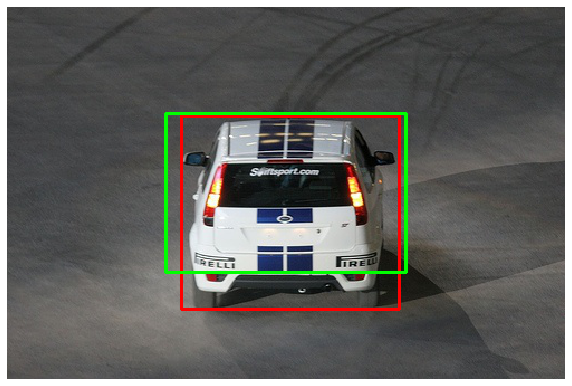

5 activated anchors!


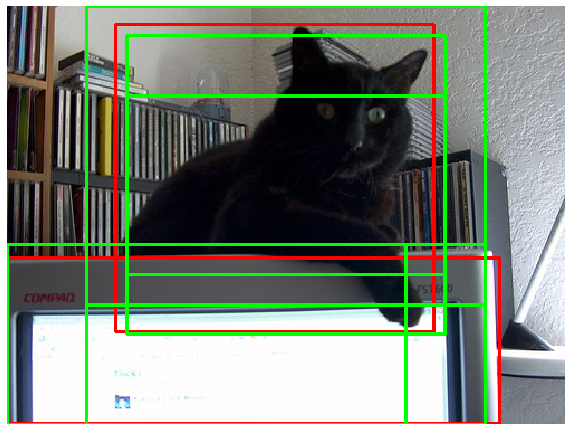

2 activated anchors!


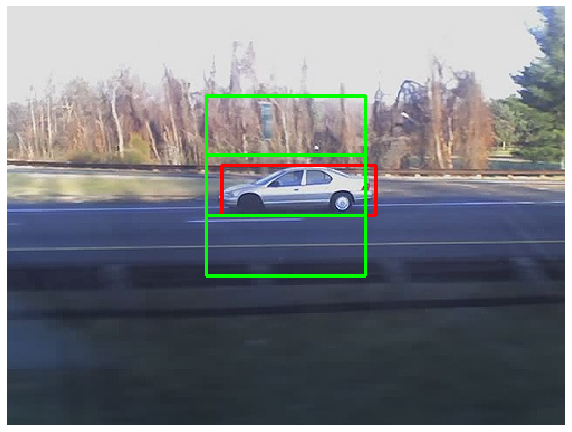

********************************************************************************
Negative anchors:


In [14]:
# visualize the activated anchors
anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1]))

print('*'*80)
print('Activated (positive) anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
  print('{} activated anchors!'.format(torch.sum(anc_ind_in_img)))
  eecs598.vis.detection_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(activated_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

print('*'*80)
print('Negative anchors:')
# for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
#   anc_ind_in_img = (negative_anc_ind >= idx * anc_per_img) & (negative_anc_ind < (idx+1) * anc_per_img)
#   print('{} negative anchors!'.format(torch.sum(anc_ind_in_img)))
#   eecs598.vis.detection_visualizer(img, idx_to_class, bbox[:, :4].to(torch.int), coord_trans(negative_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]).to(torch.int))

## Proposal module
Similar to the Prediction Networks in A5-1, but for RPN you only need to predict the object proposal scores (from the *cls* layer) and bounding box offsets (from the *reg* layer), all of which are class-agnostic.

![pred_scores2](https://miro.medium.com/max/918/1*wB3ctS9WGNmw6pP_kjLjgg.png)

Note that here $k$ is essentially $A$. Image credit: Ren et al, "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks", NeurIPS 2015, https://arxiv.org/abs/1506.01497

Implement the forward pass of `ProposalNetwork` in `two_stage_detector.py`. Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [15]:
from two_stage_detector import ProposalModule

# sanity check
reset_seed(0)
prop_module = ProposalModule(1280, drop_ratio=0).to(dtype=torch.float32, device=device)
features = torch.linspace(-10., 10., steps=3*1280*7*7, dtype=torch.float32, device=device).view(3, 1280, 7, 7)
conf_scores, offsets, proposals = prop_module(features, activated_anc_coord, \
              pos_anchor_idx=activated_anc_ind, neg_anchor_idx=negative_anc_ind)

expected_conf_scores = torch.tensor([[-0.50843990,  2.62025023],
                                     [-0.55775326, -0.29983672],
                                     [-0.55796617, -0.30000290],
                                     [ 0.17819080, -0.42211828],
                                     [-0.51439995, -0.47708601],
                                     [-0.51439744, -0.47703803],
                                     [ 0.63225138,  2.71269488],
                                     [ 0.63224381,  2.71290708]],
                                    dtype=torch.float32, device=device)
expected_offsets = torch.tensor([[ 1.62754285,  1.35253453, -1.85451591, -1.77882397],
                                 [-0.33651856, -0.14402901, -0.07458937, -0.27201492],
                                 [-0.33671042, -0.14398587, -0.07479107, -0.27199429],
                                 [ 0.06847382,  0.21062726,  0.09334904, -0.02446130],
                                 [ 0.16506940, -0.30296192,  0.29626080,  0.32173073],
                                 [ 0.16507357, -0.30302414,  0.29625297,  0.32169008],
                                 [ 1.59992146, -0.75236654,  1.66449440,  2.05138564],
                                 [ 1.60008609, -0.75249159,  1.66474164,  2.05162382]], 
                                dtype=torch.float32, device=device)

print('conf scores error: ', rel_error(conf_scores[:8], expected_conf_scores))
print('offsets error: ', rel_error(offsets, expected_offsets))

conf scores error:  1.0
offsets error:  0.9080571046834959


## Loss Function
The confidence score regression loss is for both activated/negative anchors while the bounding box regression loss loss is for activated anchors only. 


The loss functions `ConfScoreRegression` and `BboxRegression` are both found in `two_stage_detection.py`. Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [16]:
from two_stage_detector import ConfScoreRegression, BboxRegression

conf_loss = ConfScoreRegression(conf_scores, features.shape[0])
reg_loss = BboxRegression(offsets, GT_offsets, features.shape[0])
print('conf loss: {:.4f}, reg loss: {:.4f}'.format(conf_loss, reg_loss))

loss_all = torch.tensor([conf_loss.data, reg_loss.data], dtype=torch.float32, device=device)
expected_loss = torch.tensor([8.55673981, 5.10593748], dtype=torch.float32, device=device)

print('loss error: ', rel_error(loss_all, expected_loss))

conf loss: 37.3359, reg loss: 42.2634
loss error:  0.7844202173480802


## RPN module
Implement Region Proposal Network. Should resemble the `SingleStageDetector` module from A5-1, but without the class prediction. Implement RPN in `two_stage_detector.py`. 

## RPN solver
In Faster R-CNN, the RPN is trained jointly with the second-stage network. However, to test our RPN implementation, we will first train just the RPN; this is basically a class-agnostic single-stage detector, that only classifies regions as object or background.

In [17]:
RPNSolver = DetectionSolver # the same solver as in YOLO

## RPN - Overfit small data
First we will overfit the RPN on a small subset of the PASCAL VOC 2007 dataset. After training you should see a loss around or less than 3.0.

lr:  0.001
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 0 / 10) loss: 159.8642 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 1 / 10) loss: 526.3468 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 2 / 10) loss: 66.5402 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 3 / 10) loss: 44.4862 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 4 / 10) loss: 31.0666 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 5 / 10) loss: 20.4910 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 6 / 10) loss: 18.7006 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 7 / 10) loss: 19.0867 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 8 / 10) loss: 15.1768 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 9 / 10) loss: 15.2527 time per epoch: 0.1s


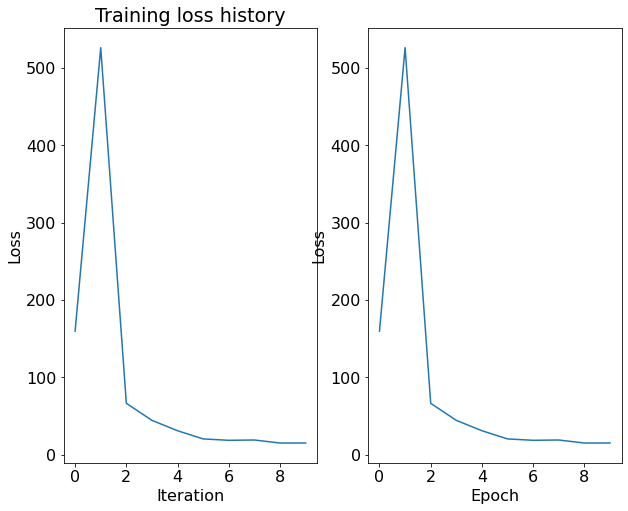

In [18]:
from two_stage_detector import RPN

# monitor the training loss
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-3]:
  print('lr: ', lr)
  rpn = RPN()
  RPNSolver(rpn, small_train_loader, learning_rate=lr, num_epochs=10, dtype=torch.float32, device=device)

## RPN - Inference
We will now visualize the predicted boxes from the RPN that we overfit to a small training sample. We will reuse the `DetectionInference` function from the previous notebook.

In [19]:
RPNInference = DetectionInference

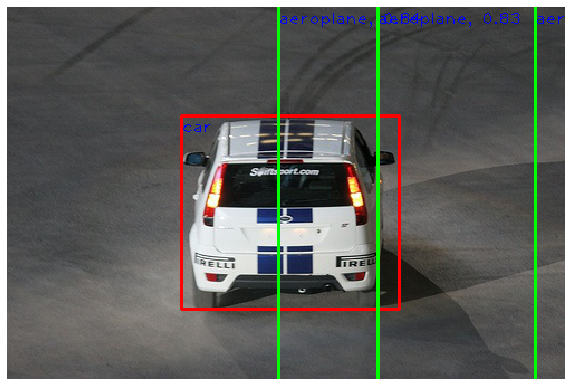

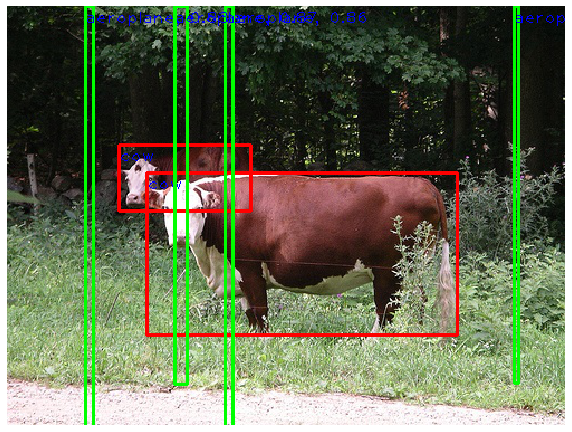

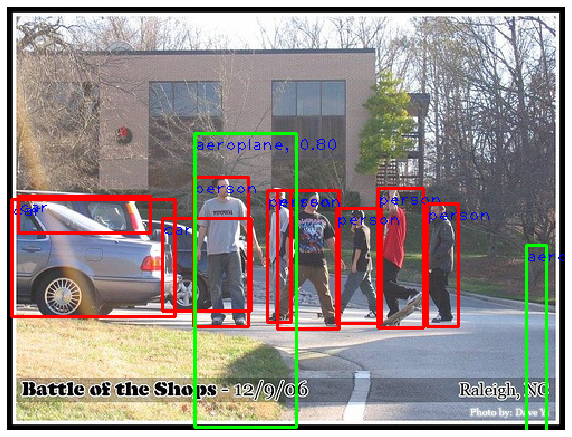

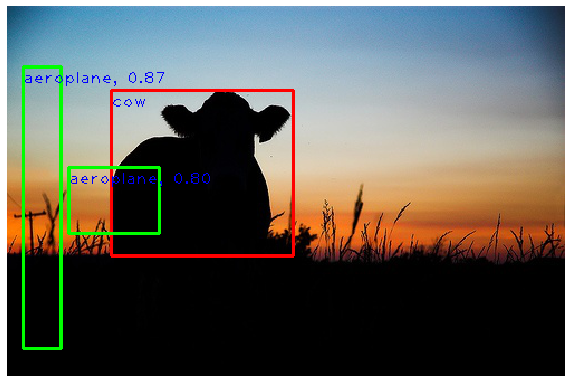

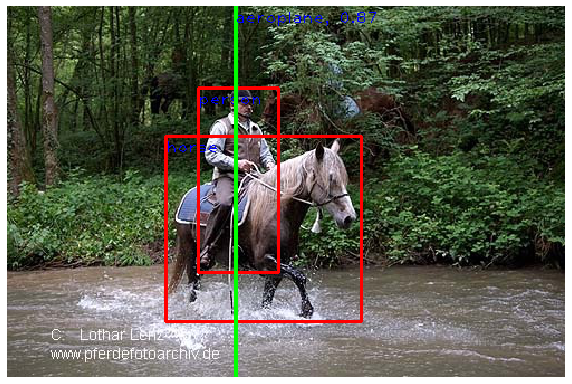

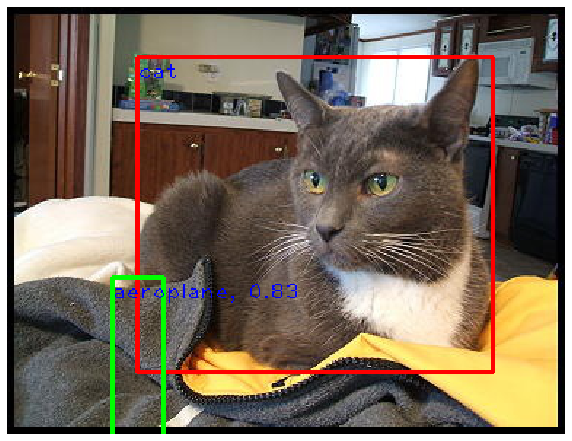

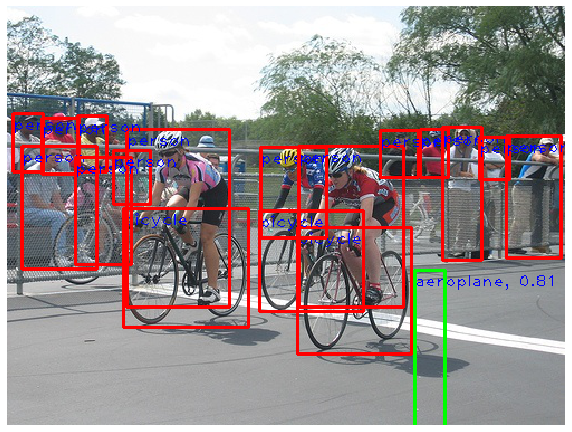

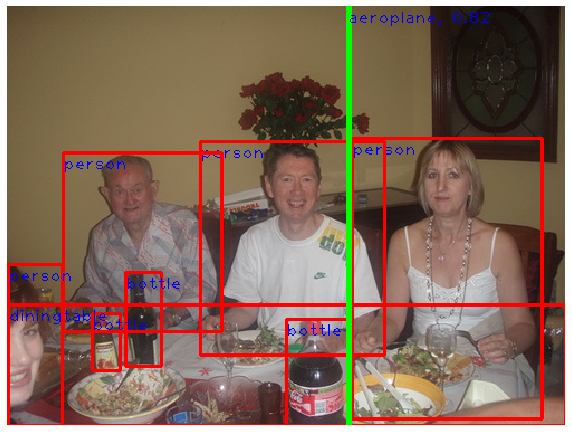

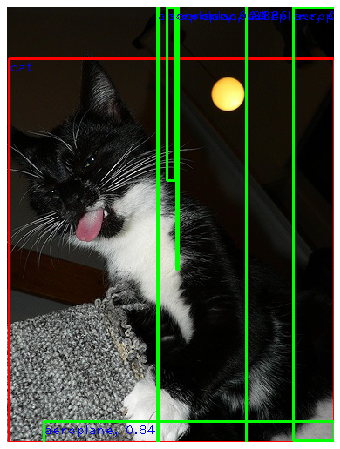

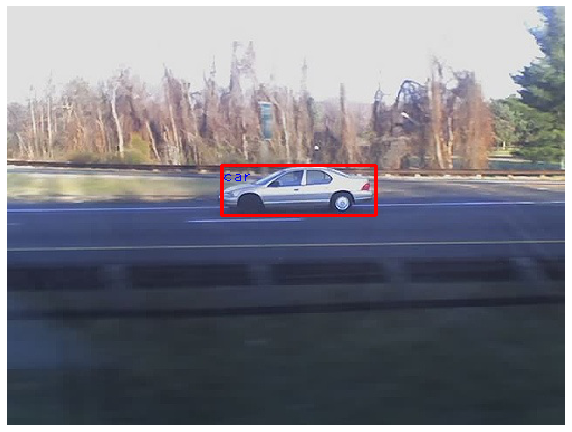

Total inference time: 1.6s


In [20]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
# ignore the dummy object class (in blue) as RPN does not output class!
RPNInference(rpn, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, device=device, dtype=torch.float32)

# Faster R-CNN
We have implemented the first half of Faster R-CNN, i.e., RPN, which is class-agnostic. Here, we briefly describe the second half Fast R-CNN.

Given the proposals or region of interests (RoI) from RPN, we warp each region from CNN activation map to a fixed size 2x2 by using [RoI Align](https://arxiv.org/pdf/1703.06870.pdf). Essentially, the RoI feature is determined by bilinear interpolation over the CNN activation map. We meanpool the RoI feature over the spatial dimension (2x2).

Finally, we classify the meanpooled RoI feature into class probabilities.

For simplicity, our two-stage detector here differs from a full Faster R-CNN system in a few aspects.
1. In a full implementation, the second stage of the network would predict a second set of offsets to transform the region proposal into a final predicted object bounding box. However we omit this for simplicity.
2. In a full implementation, the second stage of the network should be able to reject negative boxes -- in other words, if we want to predict C different object categories then the final classification layer of the second stage would predict a distribution over C+1 categories, with an extra one for background. We omit this, as it requires extra bookeeping in the second stage about which proposals are positive / negative; so for simplicity our second stage will only predict a distribution over C categories, and we will assume that the RPN has filtered out all background regions.

## RoI Align
We will use the `roi_align` function from `torchvision`. Usage see https://pytorch.org/docs/stable/torchvision/ops.html#torchvision.ops.roi_align

## Overfit small data

Implement the TwoStageDetector network in `two_stage_detector.py`. You can then test your implementation by overfitting the full Faster R-CNN network on a small subset of the training data. After training you should see a final loss less than 4.0.

number of pos proposals:  50
(Iter 0 / 1)
(Epoch 0 / 10) loss: 32.6093 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 1 / 10) loss: 60.2901 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 2 / 10) loss: 29.3631 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 3 / 10) loss: 21.7851 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 4 / 10) loss: 19.6771 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 5 / 10) loss: 18.2633 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 6 / 10) loss: 17.7718 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 7 / 10) loss: 17.1056 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 8 / 10) loss: 17.1806 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 9 / 10) loss: 17.1348 time per epoch: 0.1s


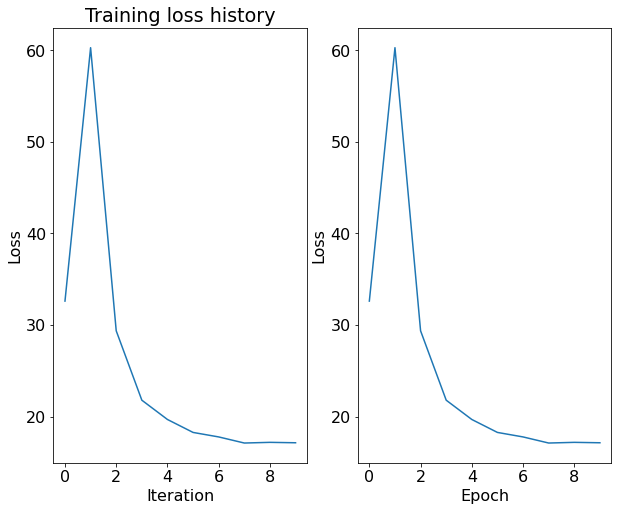

In [21]:
from two_stage_detector import TwoStageDetector
# monitor the training loss

lr = 1e-3
detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=10, dtype=torch.float32, device='cuda')

### Inference

In [ ]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, dtype=torch.float32, device='cuda')

## Train a net
Now it's time to train the full Faster R-CNN model on a larger subset of the the training data. We will train for 50 epochs; this should take about 30 minutes on a collab instance. You should see a total loss less than 3.0.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
from two_stage_detector import TwoStageDetector
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, batch_size=128) # a new loader

num_epochs = 65
lr = 5.5e-3
frcnn_detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(frcnn_detector, train_loader, learning_rate=lr, num_epochs=num_epochs, dtype=torch.float32, device='cuda')

number of pos proposals:  447
(Iter 0 / 20)
number of pos proposals:  522


After you've trained your model for 50 epochs, save it for submission. We reload it the weights and check the model accuracy as a sanity check.  

In [24]:
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "frcnn_detector.pt")
torch.save(frcnn_detector.state_dict(), weights_path) # uncomment to save your checkpoint

frcnn_detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
frcnn_detector.load_state_dict(torch.load(weights_path)) # uncomment to load your previous checkpoint
DetectionEvaluater(frcnn_detector, train_loader, dtype=torch.float32, device='cuda')


number of pos proposals:  447
number of pos proposals:  522
number of pos proposals:  471
number of pos proposals:  436
number of pos proposals:  429
number of pos proposals:  481
number of pos proposals:  465
number of pos proposals:  443
number of pos proposals:  450
number of pos proposals:  429
number of pos proposals:  480
number of pos proposals:  457
number of pos proposals:  441
number of pos proposals:  501
number of pos proposals:  522
number of pos proposals:  484
number of pos proposals:  496
number of pos proposals:  434
number of pos proposals:  476
number of pos proposals:  247
Epoch loss: 2.1192


tensor(2.1192, device='cuda:0')

### Inference

In [ ]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
DetectionInference(frcnn_detector, small_train_loader, small_dataset, idx_to_class, device='cuda', dtype=torch.float32)

## Evaluation
Compute mean Average Precision (mAP). Introduction on mAP see lecture slides (p46-57): https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture15.pdf


Run the following to evaluate your detector on the PASCAL VOC validation set. You should see mAP at around 16% or above.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [23]:
DetectionInference(frcnn_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32)
# DetectionInference(frcnn_detector, train_loader, train_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32) # uncomment to see training mAP
!cd mAP && python main.py

000005.jpg: 5 GT bboxes and 18 proposals
000007.jpg: 1 GT bboxes and 1 proposals
000009.jpg: 4 GT bboxes and 11 proposals
000016.jpg: 1 GT bboxes and 1 proposals
000019.jpg: 2 GT bboxes and 4 proposals
000020.jpg: 1 GT bboxes and 1 proposals
000021.jpg: 4 GT bboxes and 3 proposals
000024.jpg: 1 GT bboxes and 1 proposals
000030.jpg: 3 GT bboxes and 7 proposals
000039.jpg: 1 GT bboxes and 7 proposals
000041.jpg: 3 GT bboxes and 8 proposals
000046.jpg: 1 GT bboxes and 1 proposals
000050.jpg: 10 GT bboxes and 16 proposals
000051.jpg: 3 GT bboxes and 13 proposals
000052.jpg: 6 GT bboxes and 6 proposals
000060.jpg: 5 GT bboxes and 3 proposals
000063.jpg: 2 GT bboxes and 2 proposals
000065.jpg: 1 GT bboxes and 2 proposals
000072.jpg: 2 GT bboxes and 4 proposals
000081.jpg: 9 GT bboxes and 13 proposals
000093.jpg: 2 GT bboxes and 2 proposals
000095.jpg: 2 GT bboxes and 1 proposals
000099.jpg: 1 GT bboxes and 1 proposals
000101.jpg: 2 GT bboxes and 2 proposals
000102.jpg: 2 GT bboxes and 6 prop

000806.jpg: 2 GT bboxes and 6 proposals
000808.jpg: 1 GT bboxes and 1 proposals
000814.jpg: 2 GT bboxes and 2 proposals
000815.jpg: 2 GT bboxes and 5 proposals
000816.jpg: 2 GT bboxes and 2 proposals
000826.jpg: 1 GT bboxes and 2 proposals
000831.jpg: 1 GT bboxes and 2 proposals
000832.jpg: 1 GT bboxes and 1 proposals
000834.jpg: 6 GT bboxes and 15 proposals
000842.jpg: 2 GT bboxes and 3 proposals
000843.jpg: 2 GT bboxes and 4 proposals
000847.jpg: 2 GT bboxes and 1 proposals
000848.jpg: 5 GT bboxes and 10 proposals
000854.jpg: 8 GT bboxes and 16 proposals
000855.jpg: 7 GT bboxes and 0 proposals
000857.jpg: 1 GT bboxes and 12 proposals
000862.jpg: 2 GT bboxes and 3 proposals
000863.jpg: 2 GT bboxes and 3 proposals
000868.jpg: 2 GT bboxes and 19 proposals
000872.jpg: 2 GT bboxes and 9 proposals
000874.jpg: 1 GT bboxes and 2 proposals
000876.jpg: 2 GT bboxes and 2 proposals
000878.jpg: 2 GT bboxes and 10 proposals
000879.jpg: 2 GT bboxes and 3 proposals
000880.jpg: 5 GT bboxes and 2 prop

001718.jpg: 1 GT bboxes and 1 proposals
001724.jpg: 1 GT bboxes and 3 proposals
001725.jpg: 4 GT bboxes and 3 proposals
001726.jpg: 4 GT bboxes and 13 proposals
001727.jpg: 4 GT bboxes and 3 proposals
001730.jpg: 3 GT bboxes and 3 proposals
001746.jpg: 3 GT bboxes and 6 proposals
001747.jpg: 1 GT bboxes and 1 proposals
001749.jpg: 1 GT bboxes and 5 proposals
001755.jpg: 2 GT bboxes and 2 proposals
001756.jpg: 6 GT bboxes and 12 proposals
001771.jpg: 3 GT bboxes and 1 proposals
001772.jpg: 1 GT bboxes and 4 proposals
001775.jpg: 2 GT bboxes and 3 proposals
001778.jpg: 1 GT bboxes and 3 proposals
001782.jpg: 1 GT bboxes and 1 proposals
001784.jpg: 1 GT bboxes and 1 proposals
001785.jpg: 1 GT bboxes and 3 proposals
001793.jpg: 3 GT bboxes and 3 proposals
001795.jpg: 1 GT bboxes and 3 proposals
001797.jpg: 3 GT bboxes and 4 proposals
001799.jpg: 5 GT bboxes and 13 proposals
001801.jpg: 14 GT bboxes and 13 proposals
001807.jpg: 6 GT bboxes and 10 proposals
001816.jpg: 1 GT bboxes and 2 prop

002578.jpg: 1 GT bboxes and 1 proposals
002584.jpg: 5 GT bboxes and 9 proposals
002585.jpg: 4 GT bboxes and 11 proposals
002586.jpg: 1 GT bboxes and 0 proposals
002589.jpg: 8 GT bboxes and 27 proposals
002593.jpg: 1 GT bboxes and 2 proposals
002598.jpg: 1 GT bboxes and 2 proposals
002600.jpg: 1 GT bboxes and 3 proposals
002605.jpg: 6 GT bboxes and 9 proposals
002606.jpg: 5 GT bboxes and 10 proposals
002613.jpg: 6 GT bboxes and 12 proposals
002615.jpg: 2 GT bboxes and 16 proposals
002618.jpg: 1 GT bboxes and 3 proposals
002621.jpg: 2 GT bboxes and 2 proposals
002632.jpg: 1 GT bboxes and 1 proposals
002633.jpg: 2 GT bboxes and 4 proposals
002636.jpg: 8 GT bboxes and 23 proposals
002637.jpg: 2 GT bboxes and 1 proposals
002641.jpg: 4 GT bboxes and 2 proposals
002643.jpg: 4 GT bboxes and 10 proposals
002646.jpg: 1 GT bboxes and 4 proposals
002649.jpg: 4 GT bboxes and 9 proposals
002657.jpg: 3 GT bboxes and 6 proposals
002658.jpg: 8 GT bboxes and 20 proposals
002659.jpg: 1 GT bboxes and 8 pr

003422.jpg: 5 GT bboxes and 10 proposals
003425.jpg: 1 GT bboxes and 5 proposals
003429.jpg: 2 GT bboxes and 4 proposals
003435.jpg: 2 GT bboxes and 21 proposals
003443.jpg: 1 GT bboxes and 1 proposals
003444.jpg: 1 GT bboxes and 4 proposals
003449.jpg: 4 GT bboxes and 6 proposals
003451.jpg: 4 GT bboxes and 16 proposals
003453.jpg: 2 GT bboxes and 4 proposals
003455.jpg: 2 GT bboxes and 3 proposals
003458.jpg: 2 GT bboxes and 1 proposals
003461.jpg: 13 GT bboxes and 0 proposals
003462.jpg: 5 GT bboxes and 5 proposals
003464.jpg: 1 GT bboxes and 2 proposals
003465.jpg: 1 GT bboxes and 4 proposals
003468.jpg: 2 GT bboxes and 6 proposals
003469.jpg: 3 GT bboxes and 3 proposals
003470.jpg: 10 GT bboxes and 6 proposals
003492.jpg: 3 GT bboxes and 7 proposals
003516.jpg: 9 GT bboxes and 17 proposals
003518.jpg: 3 GT bboxes and 5 proposals
003519.jpg: 1 GT bboxes and 0 proposals
003521.jpg: 5 GT bboxes and 7 proposals
003528.jpg: 8 GT bboxes and 12 proposals
003530.jpg: 2 GT bboxes and 2 pro

004364.jpg: 4 GT bboxes and 12 proposals
004368.jpg: 3 GT bboxes and 6 proposals
004369.jpg: 2 GT bboxes and 5 proposals
004380.jpg: 3 GT bboxes and 5 proposals
004384.jpg: 2 GT bboxes and 3 proposals
004390.jpg: 1 GT bboxes and 3 proposals
004396.jpg: 1 GT bboxes and 1 proposals
004397.jpg: 1 GT bboxes and 6 proposals
004405.jpg: 4 GT bboxes and 6 proposals
004409.jpg: 1 GT bboxes and 1 proposals
004411.jpg: 1 GT bboxes and 3 proposals
004421.jpg: 8 GT bboxes and 10 proposals
004423.jpg: 3 GT bboxes and 3 proposals
004424.jpg: 5 GT bboxes and 22 proposals
004429.jpg: 2 GT bboxes and 3 proposals
004430.jpg: 1 GT bboxes and 1 proposals
004432.jpg: 1 GT bboxes and 1 proposals
004433.jpg: 4 GT bboxes and 3 proposals
004437.jpg: 7 GT bboxes and 1 proposals
004438.jpg: 4 GT bboxes and 4 proposals
004446.jpg: 2 GT bboxes and 8 proposals
004450.jpg: 1 GT bboxes and 1 proposals
004455.jpg: 2 GT bboxes and 1 proposals
004457.jpg: 3 GT bboxes and 10 proposals
004459.jpg: 6 GT bboxes and 11 propo

005315.jpg: 2 GT bboxes and 3 proposals
005319.jpg: 1 GT bboxes and 1 proposals
005320.jpg: 1 GT bboxes and 4 proposals
005325.jpg: 1 GT bboxes and 5 proposals
005326.jpg: 12 GT bboxes and 9 proposals
005328.jpg: 1 GT bboxes and 0 proposals
005331.jpg: 5 GT bboxes and 2 proposals
005340.jpg: 1 GT bboxes and 2 proposals
005343.jpg: 2 GT bboxes and 5 proposals
005346.jpg: 3 GT bboxes and 5 proposals
005348.jpg: 2 GT bboxes and 3 proposals
005349.jpg: 3 GT bboxes and 0 proposals
005350.jpg: 1 GT bboxes and 2 proposals
005352.jpg: 1 GT bboxes and 3 proposals
005355.jpg: 2 GT bboxes and 4 proposals
005365.jpg: 1 GT bboxes and 1 proposals
005367.jpg: 1 GT bboxes and 2 proposals
005370.jpg: 1 GT bboxes and 4 proposals
005371.jpg: 2 GT bboxes and 4 proposals
005378.jpg: 1 GT bboxes and 19 proposals
005379.jpg: 1 GT bboxes and 1 proposals
005380.jpg: 2 GT bboxes and 1 proposals
005383.jpg: 1 GT bboxes and 1 proposals
005384.jpg: 2 GT bboxes and 4 proposals
005385.jpg: 4 GT bboxes and 4 proposal

006161.jpg: 11 GT bboxes and 19 proposals
006163.jpg: 1 GT bboxes and 2 proposals
006184.jpg: 1 GT bboxes and 0 proposals
006185.jpg: 5 GT bboxes and 16 proposals
006188.jpg: 4 GT bboxes and 12 proposals
006190.jpg: 1 GT bboxes and 2 proposals
006198.jpg: 10 GT bboxes and 22 proposals
006201.jpg: 2 GT bboxes and 5 proposals
006202.jpg: 3 GT bboxes and 10 proposals
006203.jpg: 2 GT bboxes and 1 proposals
006206.jpg: 3 GT bboxes and 14 proposals
006209.jpg: 2 GT bboxes and 8 proposals
006212.jpg: 1 GT bboxes and 6 proposals
006214.jpg: 1 GT bboxes and 14 proposals
006215.jpg: 3 GT bboxes and 1 proposals
006216.jpg: 4 GT bboxes and 3 proposals
006218.jpg: 2 GT bboxes and 3 proposals
006219.jpg: 1 GT bboxes and 1 proposals
006220.jpg: 8 GT bboxes and 17 proposals
006222.jpg: 2 GT bboxes and 3 proposals
006233.jpg: 1 GT bboxes and 6 proposals
006234.jpg: 1 GT bboxes and 3 proposals
006235.jpg: 11 GT bboxes and 10 proposals
006240.jpg: 1 GT bboxes and 8 proposals
006241.jpg: 7 GT bboxes and 

006965.jpg: 6 GT bboxes and 1 proposals
006966.jpg: 1 GT bboxes and 1 proposals
006972.jpg: 4 GT bboxes and 21 proposals
006981.jpg: 1 GT bboxes and 8 proposals
006987.jpg: 3 GT bboxes and 16 proposals
006988.jpg: 2 GT bboxes and 2 proposals
006989.jpg: 2 GT bboxes and 1 proposals
006990.jpg: 2 GT bboxes and 7 proposals
006994.jpg: 1 GT bboxes and 2 proposals
006995.jpg: 1 GT bboxes and 19 proposals
007004.jpg: 6 GT bboxes and 10 proposals
007008.jpg: 2 GT bboxes and 4 proposals
007009.jpg: 1 GT bboxes and 0 proposals
007020.jpg: 1 GT bboxes and 3 proposals
007021.jpg: 5 GT bboxes and 14 proposals
007022.jpg: 1 GT bboxes and 4 proposals
007031.jpg: 2 GT bboxes and 6 proposals
007035.jpg: 3 GT bboxes and 7 proposals
007038.jpg: 1 GT bboxes and 3 proposals
007042.jpg: 6 GT bboxes and 8 proposals
007046.jpg: 2 GT bboxes and 6 proposals
007048.jpg: 7 GT bboxes and 8 proposals
007049.jpg: 3 GT bboxes and 5 proposals
007052.jpg: 3 GT bboxes and 5 proposals
007054.jpg: 1 GT bboxes and 2 propo

007727.jpg: 4 GT bboxes and 9 proposals
007732.jpg: 3 GT bboxes and 1 proposals
007742.jpg: 1 GT bboxes and 2 proposals
007743.jpg: 1 GT bboxes and 3 proposals
007745.jpg: 2 GT bboxes and 2 proposals
007746.jpg: 6 GT bboxes and 3 proposals
007754.jpg: 5 GT bboxes and 0 proposals
007758.jpg: 1 GT bboxes and 18 proposals
007760.jpg: 2 GT bboxes and 1 proposals
007763.jpg: 7 GT bboxes and 23 proposals
007765.jpg: 1 GT bboxes and 2 proposals
007768.jpg: 2 GT bboxes and 1 proposals
007772.jpg: 1 GT bboxes and 2 proposals
007773.jpg: 1 GT bboxes and 0 proposals
007776.jpg: 5 GT bboxes and 2 proposals
007779.jpg: 3 GT bboxes and 4 proposals
007786.jpg: 4 GT bboxes and 13 proposals
007793.jpg: 5 GT bboxes and 9 proposals
007798.jpg: 1 GT bboxes and 1 proposals
007799.jpg: 16 GT bboxes and 18 proposals
007812.jpg: 2 GT bboxes and 11 proposals
007813.jpg: 3 GT bboxes and 13 proposals
007815.jpg: 3 GT bboxes and 2 proposals
007824.jpg: 1 GT bboxes and 1 proposals
007826.jpg: 7 GT bboxes and 22 pr

008592.jpg: 8 GT bboxes and 2 proposals
008601.jpg: 4 GT bboxes and 5 proposals
008604.jpg: 8 GT bboxes and 17 proposals
008606.jpg: 1 GT bboxes and 2 proposals
008607.jpg: 2 GT bboxes and 5 proposals
008608.jpg: 1 GT bboxes and 1 proposals
008612.jpg: 2 GT bboxes and 3 proposals
008620.jpg: 1 GT bboxes and 1 proposals
008621.jpg: 1 GT bboxes and 1 proposals
008624.jpg: 6 GT bboxes and 20 proposals
008635.jpg: 1 GT bboxes and 1 proposals
008636.jpg: 3 GT bboxes and 4 proposals
008638.jpg: 3 GT bboxes and 1 proposals
008639.jpg: 3 GT bboxes and 9 proposals
008644.jpg: 5 GT bboxes and 7 proposals
008647.jpg: 1 GT bboxes and 2 proposals
008653.jpg: 1 GT bboxes and 2 proposals
008654.jpg: 1 GT bboxes and 3 proposals
008667.jpg: 1 GT bboxes and 3 proposals
008680.jpg: 5 GT bboxes and 14 proposals
008683.jpg: 1 GT bboxes and 1 proposals
008687.jpg: 1 GT bboxes and 2 proposals
008692.jpg: 5 GT bboxes and 4 proposals
008695.jpg: 2 GT bboxes and 6 proposals
008698.jpg: 1 GT bboxes and 3 proposa

009479.jpg: 3 GT bboxes and 5 proposals
009480.jpg: 3 GT bboxes and 9 proposals
009481.jpg: 12 GT bboxes and 20 proposals
009484.jpg: 3 GT bboxes and 5 proposals
009494.jpg: 2 GT bboxes and 7 proposals
009500.jpg: 4 GT bboxes and 6 proposals
009502.jpg: 1 GT bboxes and 3 proposals
009507.jpg: 4 GT bboxes and 6 proposals
009517.jpg: 3 GT bboxes and 13 proposals
009519.jpg: 4 GT bboxes and 2 proposals
009527.jpg: 3 GT bboxes and 2 proposals
009531.jpg: 1 GT bboxes and 0 proposals
009532.jpg: 6 GT bboxes and 17 proposals
009533.jpg: 2 GT bboxes and 6 proposals
009540.jpg: 2 GT bboxes and 8 proposals
009543.jpg: 6 GT bboxes and 13 proposals
009546.jpg: 3 GT bboxes and 2 proposals
009550.jpg: 10 GT bboxes and 10 proposals
009558.jpg: 10 GT bboxes and 1 proposals
009560.jpg: 1 GT bboxes and 1 proposals
009565.jpg: 2 GT bboxes and 3 proposals
009567.jpg: 2 GT bboxes and 3 proposals
009568.jpg: 2 GT bboxes and 4 proposals
009571.jpg: 1 GT bboxes and 3 proposals
009580.jpg: 1 GT bboxes and 0 pr

# Submit Your Work
After completing both notebooks for this assignment (`single_stage_detector_yolo.ipynb` and this notebook, `two_stage_detector_faster_rcnn.ipynb`), run the following cell to create a `.zip` file for you to download and turn in. **Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from eecs598.submit import make_a5_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = None
umid = None
make_a5_submission(GOOGLE_DRIVE_PATH, uniquename, umid)